Reference:
* [Notebook](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/ungradedLab/Wlfvj/implement-a-fully-convolutional-neural-network) in course "Advanced Computer Vision with TensorFlow" by DeepLearning.AI
* [Image segmentation tutorial](https://www.tensorflow.org/tutorials/images/segmentation) on tensorflow.org
* https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [2]:
all_class_names = ['background', 'building', 'woodland', 'water', 'road']

## Load and prepare dataset

Dataset classes names and corresponding values for pixels in masks are shown below.

| Value  | Class Name    |
| -------| -------------| 
| 0      | background |
| 1      | building      |
| 2      | woodland      |
| 3      | water |
| 4      | road     |

Each mask has shape `(512, 512, 3)` where third channel is responsible for providing information about class to which particular pixel belongs. 

For example if we'll acces a pixel of a road **`mask_as_array[height, width, :]`** the result will be list **`[4, 4, 4]`** denoting the pixel as a road class.

For further explanation open [notebook](https://github.com/MortenTabaka/roads-semantic-segmentation-in-LandCover.ai-dataset_graduate-thesis/blob/main/notebooks/exploratory/0.1-Marcin-verify_mask_convention_for_classes.ipynb).

For this project label mask will be reshaped from `(height, width, 3)` to `(height, width, num_of_classes)` with each slice along the third axis having `1` if it belongs to the class corresponding to that slice's index else `0`.

So if a pixel is part of a road, then **`mask_as_array[height, width, :] = [0, 0, 0, 0, 1]`**

The project is aiming to distinguish roads and everything else, then there will be only two classes: **background** and **road**.


In [3]:
class_names = ['background', 'road']

In [4]:
TRAIN_PATH = '/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train'
img_name = 'N-34-140-A-d-4-2_310.jpg'
mask_name = 'N-34-140-A-d-4-2_310_m.png'

IMG_PATH = '{}/{}'.format(TRAIN_PATH, img_name)
MASK_PATH = '{}/{}'.format(TRAIN_PATH, mask_name)

# Prepare paths of input images and target segmentation masks

In [5]:
import os

input_dir = TRAIN_PATH
target_dir = TRAIN_PATH
img_size = (512, 512)
num_classes = 5
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 7470
/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_0.jpg | /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_0_m.png
/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_1.jpg | /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_100_m.png
/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_10.jpg | /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_102_m.png
/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M-33-20-D-c-4-2_100.jpg | /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train/M

In [6]:
type(target_img_paths)

list

# What does one input image and corresponding segmentation mask look like?

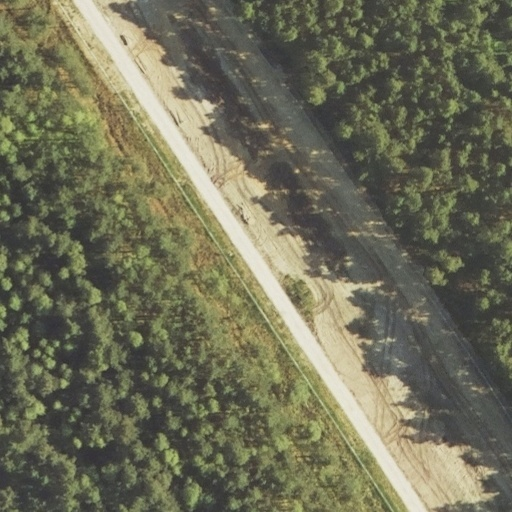

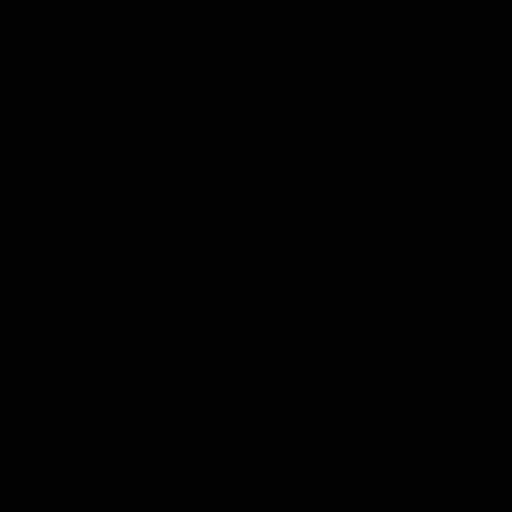

In [7]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
# img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))

img = load_img(target_img_paths[9])

img_array = np.array(img)

img_array = img_array[:, :, 0]

img = PIL.Image.fromarray(img_array)

img = PIL.ImageOps.autocontrast(img, )

display(img)


In [8]:
img_array.shape

(512, 512)

# Prepare Sequence class to load & vectorize batches of data

In [9]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class LandCover(keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        
        self.batch_size = batch_size

        self.img_size = img_size

        self.input_img_paths = input_img_paths

        self.target_img_paths = target_img_paths

    def __len__(self):

        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        
        i = idx * self.batch_size
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        
        for j, path in enumerate(batch_target_img_paths):
            im = PIL.Image.open(MASK_PATH).resize((512, 512))
            im = tf.keras.utils.to_categorical(im, len(all_class_names))
            y = np.asarray(im, dtype=np.float32)
            y = y.reshape(y.shape[0], y.shape[1], y.shape[2], len(all_class_names))
            y = y[:,:,0,:]
            y = np.expand_dims(y, axis=2)

        return x, y


In [10]:
im = PIL.Image.open(MASK_PATH).resize((512, 512))
im = tf.keras.utils.to_categorical(im, len(all_class_names))

In [11]:
im.shape

(512, 512, 3, 5)

In [12]:
y = np.asarray(im, dtype=np.float32)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], len(all_class_names))

In [13]:
y.shape

(512, 512, 3, 5)

In [14]:
y[0,250,1,:]

array([0., 0., 0., 0., 1.], dtype=float32)

In [15]:
y[3, 4, :, :]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [16]:
final_y = y[:,:,0,:]
final_y = np.expand_dims(final_y, axis=2)

In [17]:
final_y.shape

(512, 512, 1, 5)

In [21]:
final_y[56, 345, 0, :]

array([0., 1., 0., 0., 0.], dtype=float32)